<h1><img align="right" width="350" src="img/ATU-Logo-Full-RGB-Green.jpg"> Programming for Data Analysis - Project 2
</h1>
<p> 
Course: HDip in Computing in Data Analytics <br>
Module: Programming for Data Analysis <br>
Lecturer: Brian McGinley <br>
Project: Project 2 for the Programming for Data Analysis module of the HDip in Data Analytics beginning January 2023. 
    
Student: Eilis Donohue (G00006088)

Project spec:
See assessment/Project 2 - PfDA.pdf

Software Used: 
 - Python v3.10 and higher
 - Jupyter Notebook 6.5.2   
 </p>

## Table of Contents [HOLD]
- Introduction
- The CO2 and Temperature Anomaly Plot (800kyrs BP - present)

## Introduction

A number of data sources ranging from 800,000 years ago (800 kyr BP) to present data were gathered and analysed. These are:

- The CO2 measurements [1, 16], temperature anomaly [2] and CH4 [18] data from 800 kyr BP to modern times obtained from the analysis of the gas entrapped in air bubbles in ice cores drilled at various locations in Antarctica.
- The modern day CO2 level measurements from Mauna Loa [3]
- The modern day temperature anomaly data from the Global Mean Surface Temperature (GMST) analysis and trending [6, 15], measured with respect to the average temperature (1950-1980).
- The Irish temperature, precipitation measurements from around 1850 onwards [11, 17].

The pertinent data has been extracted from each of these datasources and fused together in a single dataframe located in fused_dataset/.

In [1]:
# Import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import glob
from sklearn.linear_model import LinearRegression
from scipy import signal

In [142]:
# Function definitions
# Assigns a source class to the data to allow for referencing of data
def assign_source(the_data, sources, idx_start):
  for i, source in enumerate(sources):
    the_data.loc[idx_start[i]:idx_start[i+1]-1, 'source'] = source
  return the_data

# Divide the x-axis value by 1000 (for year to kyrs)
def xaxis_format(value, pos):
    return f'{value/1000:.0f}'

# Linear Regression
def lin_reg(df_x, df_y):
  x = np.array(df_x).reshape((-1, 1))
  y = np.array(df_y)
  lr = LinearRegression()
  model = lr.fit(x,y)
  # Coefficient of determination
  r_sq = model.score(x, y) 
  return r_sq, model.coef_ , model.intercept_ , lr

# Signal lag - from https://copyprogramming.com/howto/how-to-find-the-lag-between-two-time-series-using-cross-correlation
# Positive lag means that signal y lags signal x
def signal_lag(x, y):
  correlation = signal.correlate(x - np.mean(x), y-np.mean(y), mode="full")
  lags = signal.correlation_lags(len(x), len(y), mode="full")
  lag = lags[np.argmax(abs(correlation))]
  return lag

# assigns a season class to the data to allow for referencing of data without splitting dataframe
def assign_season_class(the_data, the_class, months):
  for month in months:
    month_loc = the_data['Month'] == month
    the_data.loc[month_loc, 'season'] = the_class
  return the_data

# return the rolling mean
def rolling_seasonal_mean(data, window):
  return data.rolling(window).mean()


## The CO2 and Temperature Anomaly Plot (800kyrs BP - present)

The ice-core CO2 measurements as reported by Luthi and Bereiter, along with the Jouzel temperature data is plotted below. The temperature signal is carried by Deuterium isotope in the water (Deuterium is an isotope of Hydrogen) and hte CO2 and CH4 signals are carried by air bubbles trapped in the ice. The air bubbles trapped by ice are always deemed to be younger than the ice owing to the time lag between snow falling and it being compacted to form ice.[7]

Taking the Luthi Data (composite data) ranging from 800kyr BP to 137 yrs BP to years but substituting the Bereiter data for the period 612-800 kyr BP which was corrected and adding the later Bereiter Data, the CO2 data from 800kyr BP to approximately the year 2000 is plotted against temperature anomaly from Jouzel.

The Bereiter composite data uses the AICC2012 gas age scale whereas Luthi uses EDC3 scale. The temperature anomaly data uses the EDC3 scale (which is defined as years before 1950). There is some time lag between the Luthi and Bereiter datasets around 400kyrs BP as shown in the comparison plot below.

<figure>
<img src="https://www.euanmearns.com/wp-content/uploads/2014/11/antarctic_ice_core_stations.jpg"  width="500px">
<figcaption style = 'text-align: left' > The drill locations for the ice-core samples [7] </figcaption>
</figure>

In [3]:
# Read in Bereiter's supplementary data
CO2_comp_df = pd.read_excel('data/grl52461-sup-0003-supplementary.xls', sheet_name='CO2 Composite')
# Save the header info
CO2_comp_df_header = CO2_comp_df.iloc[:11]
# Drop the header and assign column names
CO2_comp_df.drop(CO2_comp_df.index[:14], inplace=True)
CO2_comp_df.columns=['Gasage (yr BP)', 'CO2 (ppmv)', 'sigma mean CO2 (ppmv)']
CO2_comp_df.reset_index(drop=True, inplace=True)

In [4]:
sources = CO2_comp_df_header.iloc[:11, 1]
sources = sources.values.tolist()
# Define the index start from the excel where the data is colour coded
idx_start = [0, 248, 253, 348, 638, 833, 911, 1005, 1077, 1301, 1591, 1917]
# Add source column
CO2_comp_df['source'] = ''
CO2_comp_df = assign_source(CO2_comp_df, sources, idx_start)

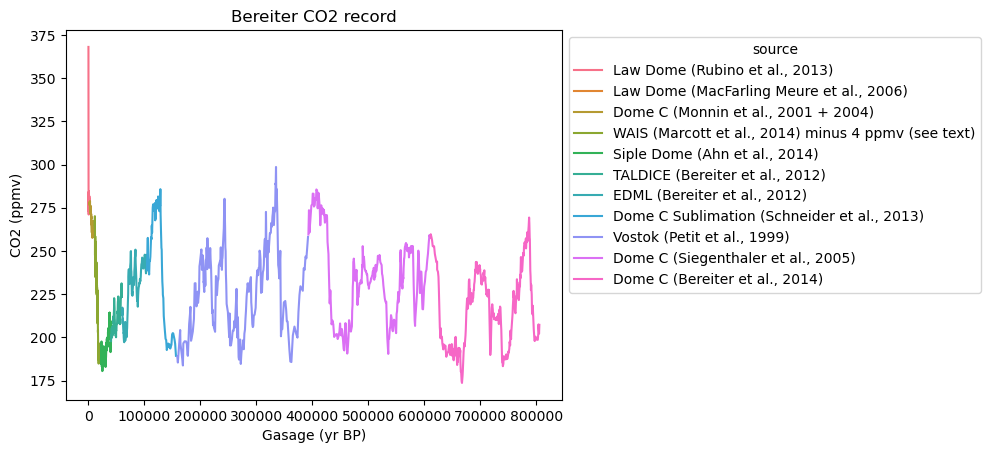

In [5]:
# The Bereiter composite data
ax = sns.lineplot(data=CO2_comp_df, x='Gasage (yr BP)', y='CO2 (ppmv)', hue='source')
ax.set_title('Bereiter CO2 record')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [6]:
# Read in Luthi Composite Data  
CO2_luthi_comp = pd.read_excel('data/41586_2008_BFnature06949_MOESM31_ESM.xls', sheet_name='3.  Composite CO2')
CO2_luthi_comp.head(10)

,Composite CO2 record (0-800 kyr BP),Unnamed: 1
0,0-22 kyr BP:,Dome C (Monnin et al. 2001) measured at Univer...
1,22-393 kyr BP:,Vostok (Petit et al. 1999; Pepin et al. 2001; ...
2,393-416 kyr BP:,Dome C (Siegenthaler et al. 2005) measured at ...
3,416-664 kyr BP:,Dome C (Siegenthaler et al. 2005) measured at...
4,664-800 kyr BP:,Dome C (Luethi et al. (sub)) measured at Unive...
5,EDC3_gas_a (yr),CO2 (ppmv)
6,137,280.4
7,268,274.9
8,279,277.9
9,395,279.1


In [7]:
CO2_luthi_comp.drop(CO2_luthi_comp.index[:6], inplace=True)
CO2_luthi_comp.columns=['EDC3_gas_a (yr)', 'CO2 (ppmv)']
CO2_luthi_comp.reset_index(drop=True, inplace=True)

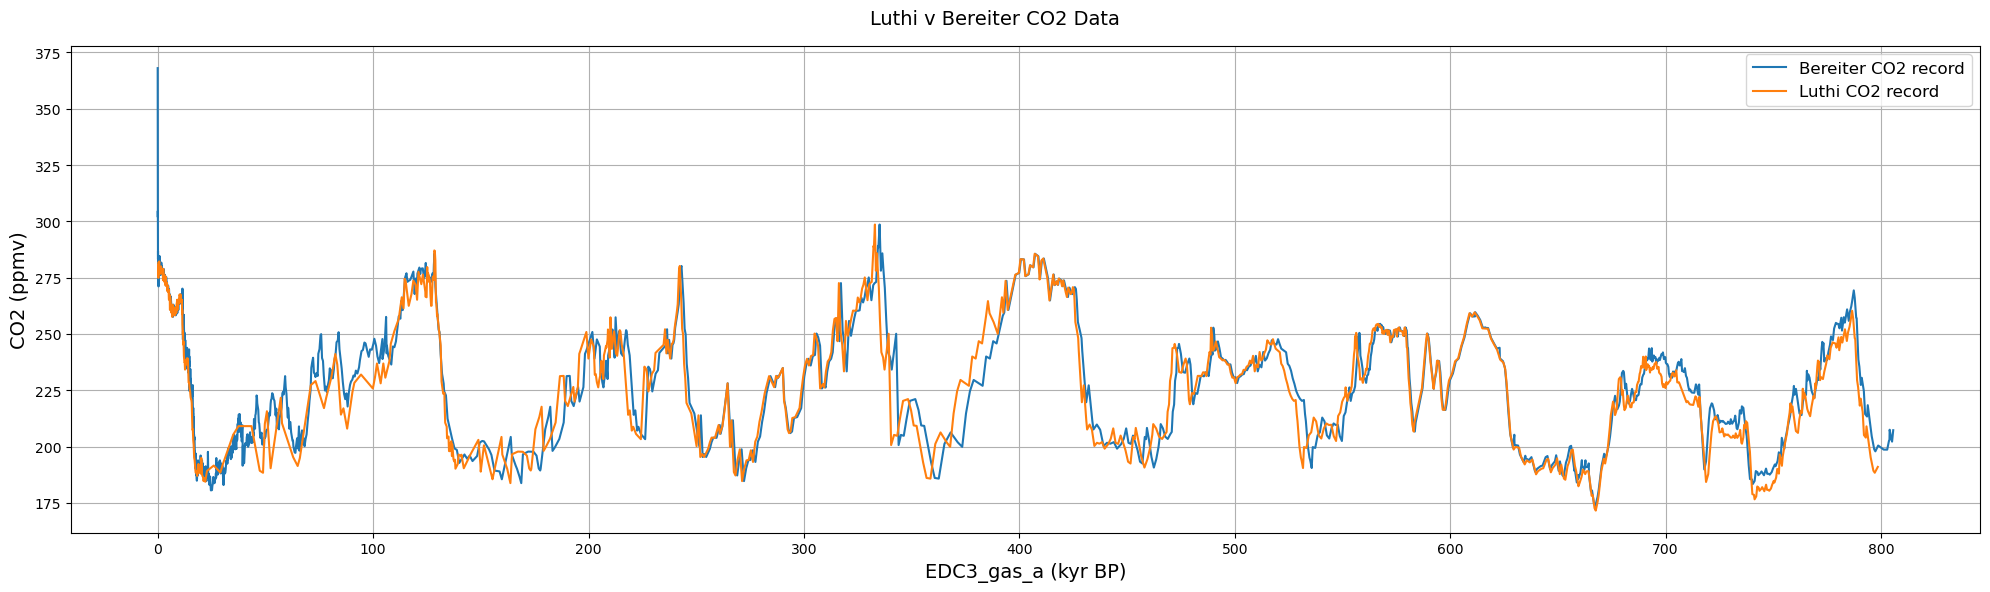

In [8]:
sources_luthi_c = ['Dome C (Monnin et al. 2001) Bern', 'Vostok (Petit et al. 1999; Pepin et al. 2001; Raynaud et al. 2005) LGGE', 'Dome C (Siegenthaler et al. 2005) LGGE', 
                   'Dome C (Siegenthaler et al. 2005) Bern', 'Dome C (Luethi et al. (sub)) Bern']
idx_luthi_c = [0, 183, 517, 537, 867, 1096]
CO2_luthi_comp['source'] = ''
CO2_luthi_comp = assign_source(CO2_luthi_comp, sources_luthi_c, idx_luthi_c)

# plot the data from the Bereiter supplementary data (composite) and the original Luthi data (composite)
fig, ax = plt.subplots(1, figsize=(20, 6))
fig.suptitle('Luthi v Bereiter CO2 Data', fontsize=14)
ax.plot(CO2_comp_df['Gasage (yr BP)'],CO2_comp_df['CO2 (ppmv)'], label='Bereiter CO2 record')
ax.plot(CO2_luthi_comp['EDC3_gas_a (yr)'], CO2_luthi_comp['CO2 (ppmv)'], label='Luthi CO2 record')
ax.legend(loc='upper right', fontsize=12)
ax.set_xlabel('EDC3_gas_a (kyr BP)', fontsize=14)
ax.set_ylabel('CO2 (ppmv)', fontsize=14)
ax.grid()
ax.xaxis.set_major_formatter(FuncFormatter(xaxis_format))
plt.tight_layout()
plt.show()


In [9]:
# Take Luthi's data and replace from 611 kyr BP with Bereither's data, add the < 137 gas age years from Bereiter also.
# Create new dataframe of Luthi data < 611000 gas age
CO2_luthi_comp_plus = CO2_luthi_comp[CO2_luthi_comp['EDC3_gas_a (yr)']<611000]
# Take the Bereiter data (the earliest and latest)
CO2_ber_subset = CO2_comp_df[(CO2_comp_df['source'] == 'Dome C (Bereiter et al., 2014)') | (CO2_comp_df['Gasage (yr BP)'] < 137)]
CO2_ber_subset = CO2_ber_subset.drop('sigma mean CO2 (ppmv)', axis=1).copy()
# change the variable names for concatenation
CO2_ber_subset.columns = CO2_luthi_comp_plus.columns
# Concatenate the Bereiter data (newest and oldest), sort based on gasage and reset the index
CO2_luthi_comp_plus = pd.concat([CO2_luthi_comp_plus, CO2_ber_subset], ignore_index=True).sort_values(by='EDC3_gas_a (yr)').reset_index(drop=True)
CO2_luthi_comp_plus

,EDC3_gas_a (yr),CO2 (ppmv),source
0,-51.03,368.022488,"Law Dome (Rubino et al., 2013)"
1,-48,361.780737,"Law Dome (Rubino et al., 2013)"
2,-46.279272,359.647793,"Law Dome (Rubino et al., 2013)"
3,-44.405642,357.10674,"Law Dome (Rubino et al., 2013)"
4,-43.08,353.946685,"Law Dome (Rubino et al., 2013)"
...,...,...,...
1280,803925.284376,202.921723,"Dome C (Bereiter et al., 2014)"
1281,804009.870607,207.498645,"Dome C (Bereiter et al., 2014)"
1282,804522.67463,204.861938,"Dome C (Bereiter et al., 2014)"
1283,805132.442334,202.226839,"Dome C (Bereiter et al., 2014)"


In [10]:
# Read in the temperature data 
temp_anom = pd.read_csv('data/edc3deuttemp2007.txt', delim_whitespace=True, skiprows=91)
temp_anom

,Bag,ztop,Age,Deuterium,Temperature
0,1,0.00,-50.00000,NaN,NaN
1,2,0.55,-43.54769,NaN,NaN
2,3,1.10,-37.41829,NaN,NaN
3,4,1.65,-31.61153,NaN,NaN
4,5,2.20,-24.51395,NaN,NaN
...,...,...,...,...,...
5795,5796,3187.25,797408.00000,-440.20,-8.73
5796,5797,3187.80,798443.00000,-439.00,-8.54
5797,5798,3188.35,799501.00000,-441.10,-8.88
5798,5799,3188.90,800589.00000,-441.42,-8.92


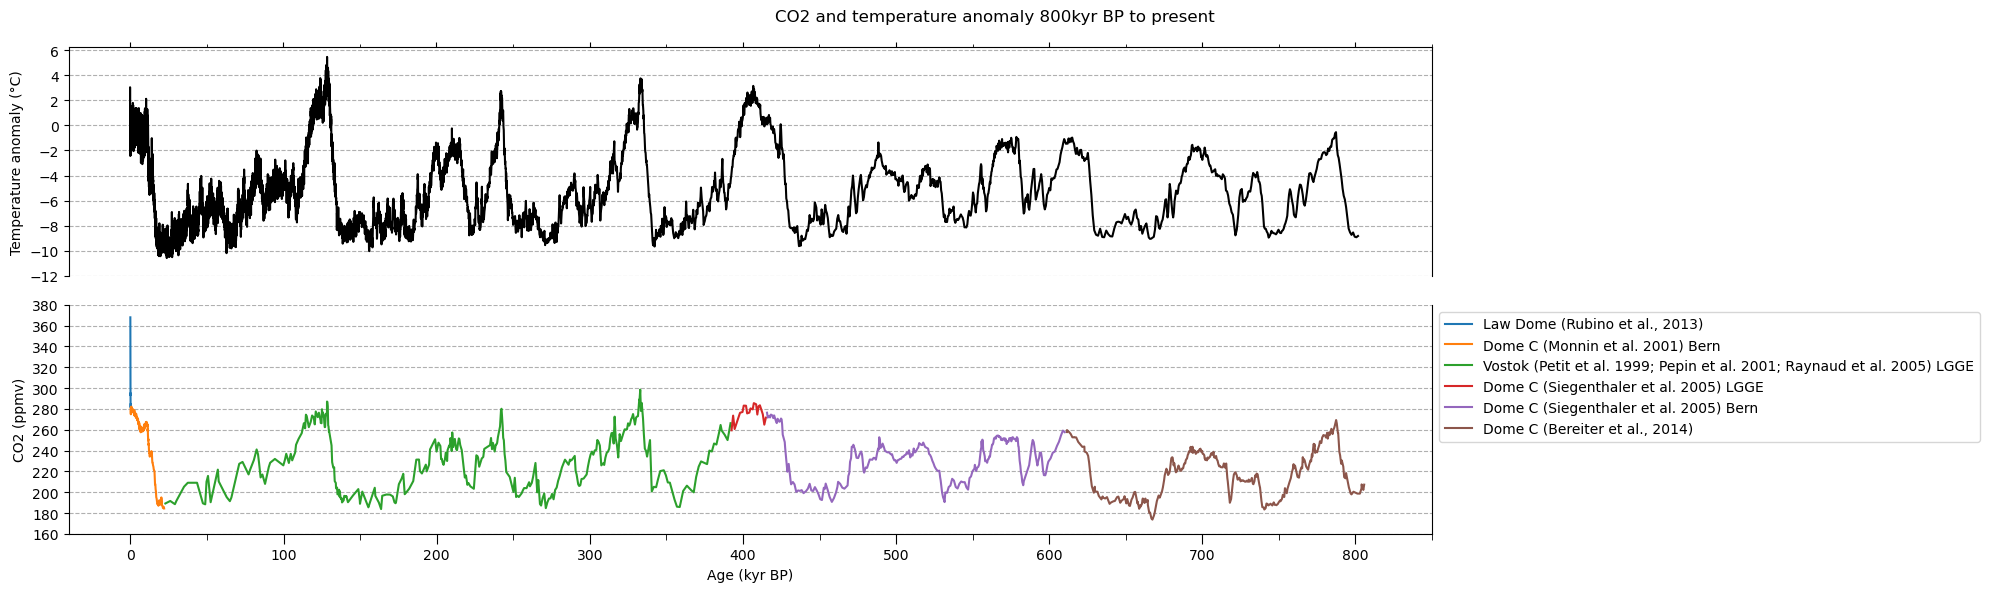

In [11]:
# Create the plot from Luthi Nature (2008) with added CO2 data from Bereither for beginning and end.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(20, 6))
fig.suptitle('CO2 and temperature anomaly 800kyr BP to present')
sns.lineplot(data=CO2_luthi_comp_plus,  x='EDC3_gas_a (yr)', y='CO2 (ppmv)', ax=ax2, hue='source')
sns.lineplot(data=temp_anom, x='Age', y='Temperature', ax=ax1, color='black')

# Format temp axis
ax1.spines['bottom'].set_visible(False)
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax1.yaxis.grid(True, linestyle='--')
ax1.xaxis.set_ticks_position('top')
ax1.set_xticks([tick for tick in range(0, 900000, 50000)], minor=True)
ax1.set(ylabel="Temperature anomaly (°C)")
ax1.set_yticks([tick for tick in range(-12, 7, 2)])
ax1.set_xticks([tick for tick in range(0, 900000, 50000)], minor=True)
ax1.set_xticks([tick for tick in range(0, 900000, 100000)])
ax1.tick_params(axis='x', which='both', bottom=False, top=True)

# Format CO2 axis
ax2.yaxis.grid(True, linestyle='--')
ax2.tick_params(axis='x', which='both', bottom=True, top=False)
ax2.tick_params(axis='x', which='major', length=7)
ax2.tick_params(axis='x', which='minor', length=4)
ax2.spines['top'].set_visible(False)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.set_yticks([tick for tick in range(160, 390, 20)])
ax2.set_xticks([tick for tick in range(0, 900000, 100000)])
ax2.set_xticks([tick for tick in range(0, 900000, 50000)], minor=True)
ax2.set(xlabel="Age (kyr BP)")
# https://matplotlib.org/stable/gallery/ticks/tick-formatters.html
ax2.xaxis.set_major_formatter(FuncFormatter(xaxis_format))

plt.tight_layout()
plt.show()

In [12]:
# Merge the CO2 and Temperature data 
# Rename the year variable in both for merge
# https://pandas.pydata.org/docs/reference/api/pandas.merge_ordered.html

climate_data_fusion = pd.DataFrame()
CO2_luthi_comp_plus.rename(columns={'EDC3_gas_a (yr)': 'Age_EDC3 (yrs BP)'}, inplace=True)
temp_anom.rename(columns={'Age': 'Age_EDC3 (yrs BP)'}, inplace=True)
climate_data_fusion = pd.merge_ordered(CO2_luthi_comp_plus, temp_anom[['Age_EDC3 (yrs BP)', 'Temperature',]], how="outer",  on='Age_EDC3 (yrs BP)')


C:\Users\eilis.donohue\AppData\Local\Temp\ipykernel_9832\2702093975.py:8: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  climate_data_fusion = pd.merge_ordered(CO2_luthi_comp_plus, temp_anom[['Age_EDC3 (yrs BP)', 'Temperature',]], how="outer",  on='Age_EDC3 (yrs BP)')


## Methane (CH4) Data (Vostok Ice Core data)

The ice cores drilled at Vostock drill location were analysed and the CH4 content was measured for the years spanning 417kyr BP to approximately 1950.

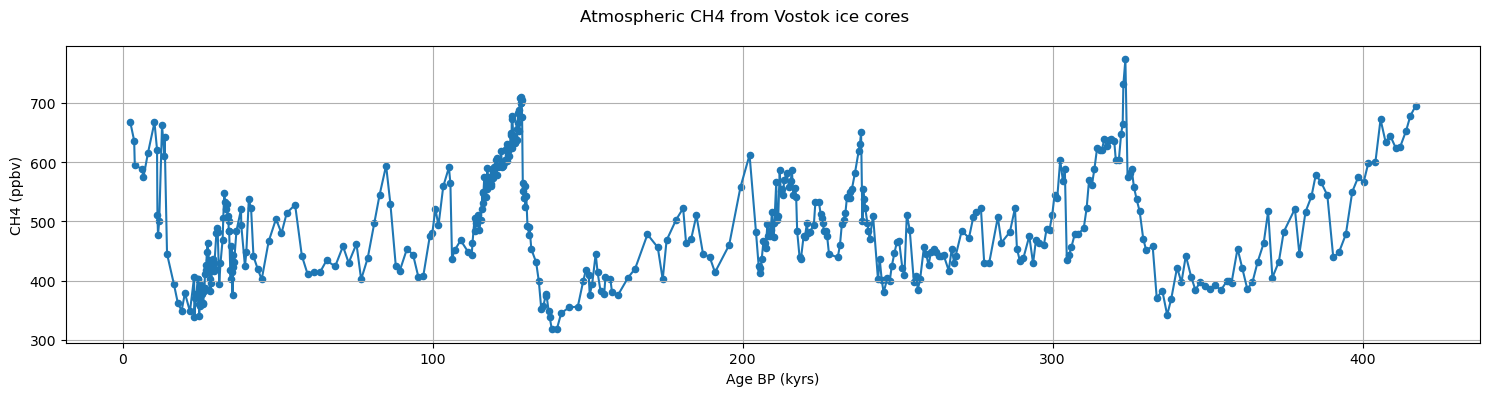

In [13]:
# Read in the CH4 data (Petit (2005))
CH4_comp = pd.read_csv('data/Vostok_CH4_CO2_age.tab', skiprows=15, sep='\t')
CH4_comp.head(10)
# Tidy the dataframe 
#CH4_comp.columns = ['Gas Age (yrs BP)', 'CH4 (ppbv)']
# Changing the years to 1000 to be consistent with CO2 data
CH4_comp['Age [ka BP]'] = CH4_comp['Age [ka BP]'] * 1000
# change the age column name
CH4_comp = CH4_comp.rename(columns={'Age [ka BP]':'Age_EDC3 (yrs BP)'})
# drop nans for plotting the line
CH4_comp_nan_drop = CH4_comp.dropna(subset=['CH4 [ppbv]'])
fig, ax = plt.subplots(1, figsize=(15, 4))
fig.suptitle('Atmospheric CH4 from Vostok ice cores')
ax.scatter(CH4_comp['Age_EDC3 (yrs BP)'], CH4_comp['CH4 [ppbv]'], s=20)
ax.plot(CH4_comp_nan_drop['Age_EDC3 (yrs BP)'], CH4_comp_nan_drop['CH4 [ppbv]'], linestyle='-');
ax.set_ylabel('CH4 (ppbv)')
ax.set_xlabel('Age BP (kyrs)')
ax.grid()
ax.xaxis.set_major_formatter(FuncFormatter(xaxis_format))
fig.tight_layout()

In [14]:
# Merge the CH4 data into the fused data dataframe

climate_data_fusion = pd.merge_ordered(climate_data_fusion,  CH4_comp, how="outer",  on='Age_EDC3 (yrs BP)')

C:\Users\eilis.donohue\AppData\Local\Temp\ipykernel_9832\3331226675.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  climate_data_fusion = pd.merge_ordered(climate_data_fusion,  CH4_comp, how="outer",  on='Age_EDC3 (yrs BP)')


## Mauna Loa CO2 data

The CO2 levels in the atmosphere have been measured at Mauna Loa in Hawaii since 1958 [5]. The yearly seasonal variation can be seen in the plot but the general upward trend is apparent with levels rising year on year.

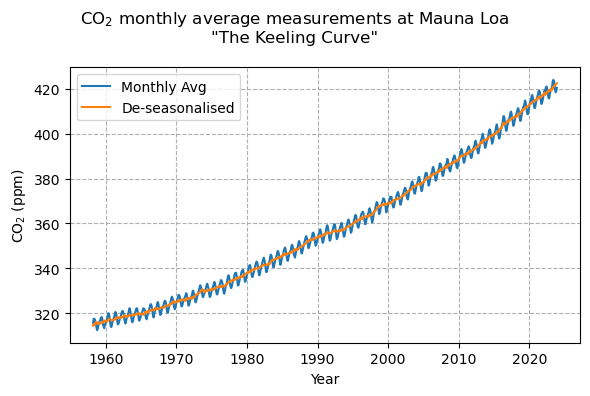

In [15]:
# Read in monthly Mauna Loa CO2 data
CO2_ML_m = pd.read_csv('data/co2_mm_mlo.txt', delim_whitespace=True, skiprows=41)
CO2_ML_m.columns = ['year', 'month', 'decimal date', 'monthly average', 'de-seasonalized', 'no_days', 'std', 'unc of mean']

# Plot Mauna Loa data
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(CO2_ML_m['decimal date'], CO2_ML_m['monthly average'], label='Monthly Avg')
ax.plot(CO2_ML_m['decimal date'], CO2_ML_m['de-seasonalized'], label='De-seasonalised')
ax.set_xlabel("Year")
ax.set_ylabel("CO$_2$ (ppm)")
fig.suptitle(f'CO$_2$ monthly average measurements at Mauna Loa\n"The Keeling Curve"')
ax.grid(True, linestyle="--")
ax.legend(loc='upper left')
fig.tight_layout()

# Add a column to convert date to EDC3 scale
CO2_ML_m['EDC3_gas_a (yr)'] = 1950 - CO2_ML_m['decimal date']


## Global Mean Surface Temperature (GMST)
The Global Mean Surface Temperature (GMST) is added to the data as an indicator of temperature / climate change globally since 1850 [15]. The data is given as temperature anomaly with respect to the Jan 1951-Dec 1980 average. It may be used to correlate with the Mauna Loa CO2 data and the later part of the ice-core CO2 data.

The temperature values where air temperatures were used in the presence of sea ice are used. The annual anomaly data was taken from this dataset.

It is included as its own data variable in the fused dataset as it is not contiguous with the temperature anomaly data calculated from the ice-core analysis. 

In [48]:
## GMST
# Read in the data from Berkeley 
GMST_anom_1850 = pd.read_csv('data/Land_and_Ocean_complete_table1.txt', skiprows=84, delim_whitespace=True)
# Trim dataset and rename columns
GMST_anom_1850 = GMST_anom_1850.drop(GMST_anom_1850.columns[[2,3,6,7,8, 9, 10]], axis=1).copy()
GMST_anom_1850.columns = ['Year', 'Month', 'GMST Anomaly Yearly', 'GMST Anomaly Uncertainty', 'GMST 20yr anomaly', 'GMST 20yr Uncertainty']
# Add decimalised year - assuming the data pertains to middle of month
GMST_anom_1850['decimal date'] = GMST_anom_1850['Year'] + ((GMST_anom_1850['Month']-1) /12)+(1/12/2)
# Add EDC3 year
GMST_anom_1850['Age_EDC3 (yrs BP)'] = 1950 - GMST_anom_1850['decimal date']
GMST_anom_1850

,Year,Month,GMST Anomaly Yearly,GMST Anomaly Uncertainty,GMST 20yr anomaly,GMST 20yr Uncertainty,decimal date,Age_EDC3 (yrs BP)
0,1850,1,NaN,NaN,NaN,NaN,1850.041667,99.958333
1,1850,2,NaN,NaN,NaN,NaN,1850.125000,99.875000
2,1850,3,NaN,NaN,NaN,NaN,1850.208333,99.791667
3,1850,4,NaN,NaN,NaN,NaN,1850.291667,99.708333
4,1850,5,NaN,NaN,NaN,NaN,1850.375000,99.625000
...,...,...,...,...,...,...,...,...
2082,2023,7,NaN,NaN,NaN,NaN,2023.541667,-73.541667
2083,2023,8,NaN,NaN,NaN,NaN,2023.625000,-73.625000
2084,2023,9,NaN,NaN,NaN,NaN,2023.708333,-73.708333
2085,2023,10,NaN,NaN,NaN,NaN,2023.791667,-73.791667


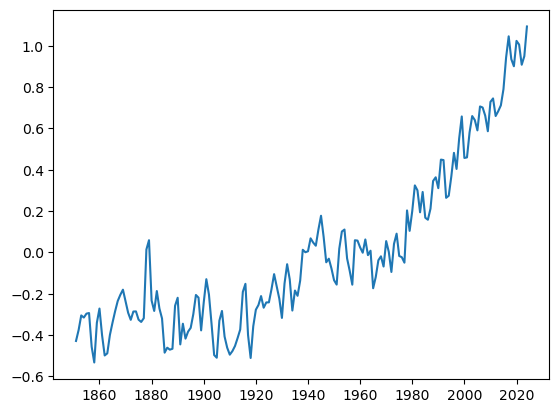

In [61]:
# Add in the HadCRUT5 data for the Northern Hemisphere
HadCRUT = pd.read_csv('data/HadCRUT.5.0.2.0.analysis.summary_series.northern_hemisphere.monthly.csv')
HadCRUT['Day'] =1
HadCRUT['datetime'] = pd.to_datetime(HadCRUT[['Year', 'Month', 'Day']])
# Monthly resample
HadCRUT.set_index('datetime', inplace=True)
HadCRUT_mean = HadCRUT.resample('Y').mean(numeric_only=True)
HadCRUT_Berkeley = pd.merge_ordered(HadCRUT, GMST_anom_1850, how='outer', on=['Year', 'Month'])
HadCRUT_Berkeley['Day'] =1
HadCRUT_Berkeley['datetime'] = pd.to_datetime(HadCRUT_Berkeley[['Year', 'Month', 'Day']])
HadCRUT_Berkeley.set_index('datetime', inplace=True)
HadCRUT_Berkeley_mean = HadCRUT_Berkeley.resample('Y').mean(numeric_only=True)

## Irish Data
### Irish historical rainfall data

The long term Irish rainfall data (from 1850 to 2010) [11], averaged monthly across 25 stations was obtained from [10]. 

The research of a climate change signal conducted by [hold] showed that annual precipitation correlation with GMST occurred at Valentia, Markree, Malin nad Mullingar stations. ((Seasonal variations were also analysed iwth Spring, only Valentia, Shannon, Mullingar and Markree showed correlation wtih GMST,)) 


In [17]:
# Read in the irish rainfall data
rain = pd.read_csv("data/Long-Term-IIP-network-1/IIP_National series.csv", skiprows=2)

year = rain['Year']
rain.drop('Year', axis=1,  inplace=True)
transposed_values = []
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-pandas-dataframe
months = []
year = []
for index, row in rain.iterrows():
    transposed_values.extend(row.values)
    months.extend(rain.columns) 
    
month_dict = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
result_series = pd.Series(transposed_values)
month_series = pd.Series(months)
# create a decimalised date series for the data - assuming here each data point is relevant to the middle of the month
date_series = np.arange(1850+(1/12/2), 2011+(1/12/2), 1/12)
year = date_series.astype('int64')
year_series = pd.Series(year)

# https://stackoverflow.com/questions/30522724/take-multiple-lists-into-dataframe
rain_ire_1850 = pd.DataFrame({'decimal date': date_series, 'Year': year_series,'Month': month_series, 'Irish rainfall (mm)': result_series})
rain_ire_1850['Month'] = rain_ire_1850['Month'].replace(month_dict)


## Irish Air Temperature Record

The historical Irish air temperature records have been gathered for various weather stations by researchers in the University of Galway in conjunction with Met Eireann [13]. The main dataset resulting from this study is called the Ireland Long-term Maximum and Minimum Air Temperature Dataset (ILMMT) and is included in the /data directory in this repository. The temperature data is being used to study the long-term climate change in Ireland and derive a signal for climate change in conjunction with long-term rainfall records [14].

In the research conducted by Murphy et al [HOLD], the annual mean temperature showed the emergence of unusual climate with Phoenix Park, Glasnevin, Dublin, Roches Point, Malin Head and Galway showing hte greatest increases.  Dublin stations showed more pronounced increases.

### Methodology

In the absence of a full composite homogenous Irish historical temperature data, a subset (/data/ilmmt_subset) of the long-term series (comprising 12 weather stations) are ingested and averaged. The min and max values are taken from each weather station and averaged with the data from other weather stations. The date is decimalised to allow fusion and comparison with the global data. 

The data for each selected station was cleaned prior to ingest by removing fahrenheit data and also consolidating more than 1 maximum or minimum reading into a single maximum and a single minimum for each day.

  - The data (min and max) was read in from the subset of cleaned csv files (/data/ilmmt_subset).
  - It was then averaged across the csv datafiles to create one maximum and one minimum dataseries
  - The daily data was then resampled to monthly data and averaged 
  - Decimalised date and EDC3 date were added to allow merging of the data with the overall fused dataset.

In [18]:
# Read in the historical (1850-circa 1950s) Ireland air temperature data (composite of a number of long-term series files)

# Specify the path to the directory containing the CSV files
directory_path = 'data\ilmmt_subset'
notebook_directory = os.path.dirname(os.path.realpath("__file__"))
# Change the current working directory to the directory of the script or notebook
os.chdir(notebook_directory)

# Use glob to get a list of all CSV files in the directory
met_files = glob.glob(os.path.join(directory_path, '*.csv'))

# Initialise dataframes to store the daily max and min temperature data
temp_ire_max = pd.DataFrame(columns = ['Year', 'Month', 'Day'])
temp_ire_min = pd.DataFrame(columns = ['Year', 'Month', 'Day'])
temp_ire_mean_1850 = pd.DataFrame(columns = ['Year', 'Month', 'Day'])

for i, file in enumerate(met_files):
  data = pd.read_csv(file)
  data_max = data[['Year', 'Month', 'Day', 'Max']]
  data_min = data[['Year', 'Month', 'Day', 'Min']]
  # rename the columns to avoid suffixing
  data_max = data_max.rename(columns={'Max':i})  
  data_min = data_min.rename(columns={'Min':i})  
  temp_ire_max = pd.merge_ordered(temp_ire_max, data_max, on=['Year', 'Month', 'Day'], how='outer')
  temp_ire_min = pd.merge_ordered(temp_ire_min, data_min, on=['Year', 'Month', 'Day'], how='outer')

# Get average across each row (average of the 12 csv files)
cols_mean = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
temp_ire_max['Average max (C)'] = temp_ire_max[cols_mean].mean(axis=1, numeric_only=True)
temp_ire_min['Average min (C)'] = temp_ire_min[cols_mean].mean(axis=1, numeric_only=True)
# Get mean
temp_ire_mean_1850['Mean Irish Air temp (deg C)'] = (temp_ire_max['Average max (C)'] + temp_ire_min['Average min (C)'])/2
temp_ire_mean_1850['Year'] = temp_ire_max['Year']
temp_ire_mean_1850['Month'] = temp_ire_max['Month']
temp_ire_mean_1850['Day'] = temp_ire_max['Day']


# Add a datetime column to allow for aggregation https://stackoverflow.com/questions/58072683/combine-year-month-and-day-in-python-to-create-a-date
temp_ire_mean_1850['datetime'] = pd.to_datetime(temp_ire_mean_1850[['Year', 'Month', 'Day']])
# Monthly resample
temp_ire_mean_1850.set_index('datetime', inplace=True)
temp_ire_mean_1850_monthly = temp_ire_mean_1850.resample('M').mean(numeric_only=True)

# Add decimalised date and EDC date for fusion etc
temp_ire_mean_1850_monthly['decimal date'] = temp_ire_mean_1850_monthly['Year'] + ((temp_ire_mean_1850_monthly['Month']-1) /12)+(1/12/2)
temp_ire_mean_1850_monthly['Age_EDC3 (yrs BP)'] = 1950 - temp_ire_mean_1850_monthly['decimal date'] 
temp_ire_mean_1850_monthly
temp_ire_mean_1850_monthly['Year'] = temp_ire_mean_1850_monthly['Year'].astype('int64').copy()
temp_ire_mean_1850_monthly['Month'] = temp_ire_mean_1850_monthly['Month'].astype('int64').copy()

In [19]:
# Read in more recent Irish air temperature data (monthly)
# Specify the path to the directory containing the CSV files
directory_path = 'data\Ireland_air_temp'
notebook_directory = os.path.dirname(os.path.realpath("__file__"))
os.chdir(notebook_directory)

# Use glob to get a list of all CSV files in the directory
met_files = glob.glob(os.path.join(directory_path, '*.csv'))
# Initialise dataframes to store the daily max and min temperature data
temp_ire_mean_modern = pd.DataFrame(columns = ['year', 'month'])

for i, file in enumerate(met_files):
  data = pd.read_csv(file, skiprows=19)
  data_mean = data[['year', 'month', 'meant']]
   # rename the columns to avoid suffixing
  data_mean = data_mean.rename(columns={'meant':i})  
  temp_ire_mean_modern = pd.merge_ordered(temp_ire_mean_modern, data_mean, on=['year', 'month'], how='outer')

# Get average across each row (average of the 5 csv files)
cols_mean = [0, 1, 2, 3, 4]
temp_ire_mean_modern['Mean Irish Air temp (deg C)'] = temp_ire_mean_modern[cols_mean].mean(axis=1)
# drop the 5 columns
temp_ire_mean_modern.drop(columns=cols_mean, inplace=True)

# Add a datetime column to allow for aggregation https://stackoverflow.com/questions/58072683/combine-year-month-and-day-in-python-to-create-a-date
temp_ire_mean_modern['day'] = 1
temp_ire_mean_modern['datetime'] = pd.to_datetime(temp_ire_mean_modern[['year', 'month', 'day']])
temp_ire_mean_modern.set_index('datetime', inplace=True)

# Add decimalised date and EDC date for fusion and plotting etc
temp_ire_mean_modern['decimal date'] = temp_ire_mean_modern['year'] + ((temp_ire_mean_modern['month']-1) /12)+(1/12/2)
temp_ire_mean_modern['Age_EDC3 (yrs BP)'] = 1950 - temp_ire_mean_modern['decimal date'] 
# Rename year and month for consistency with historical data
temp_ire_mean_modern = temp_ire_mean_modern.rename(columns={'year': 'Year', 'month': 'Month'})
temp_ire_mean_modern['Year'] = temp_ire_mean_modern['Year'].astype('int64').copy()
temp_ire_mean_modern['Month'] = temp_ire_mean_modern['Month'].astype('int64').copy()

In [20]:
# Join the historical data with the modern air temperature data

irish_air_temp_composite = pd.merge_ordered(temp_ire_mean_1850_monthly, temp_ire_mean_modern, how='outer', on=['Year', 'Month', 'decimal date', 'Age_EDC3 (yrs BP)'])
# replace the nans in _x with values from _y and vice versa
irish_air_temp_composite['Mean Irish Air temp (deg C)_x'].fillna(irish_air_temp_composite['Mean Irish Air temp (deg C)_y'], inplace=True)
irish_air_temp_composite['Mean Irish Air temp (deg C)_y'].fillna(irish_air_temp_composite['Mean Irish Air temp (deg C)_x'], inplace=True)
# Now get the average which takes care of the overlapping values
irish_air_temp_composite['Mean Irish Air temp (deg C)'] = (irish_air_temp_composite['Mean Irish Air temp (deg C)_x'] + irish_air_temp_composite['Mean Irish Air temp (deg C)_y'])/2
# drop unwanted
irish_air_temp_composite.drop(columns=['Day', 'day', 'Mean Irish Air temp (deg C)_x', 'Mean Irish Air temp (deg C)_y'], inplace=True)
irish_air_temp_composite


,Year,Month,decimal date,Age_EDC3 (yrs BP),Mean Irish Air temp (deg C)
0,1831,1,1831.041667,118.958333,3.550000
1,1831,2,1831.125000,118.875000,5.234211
2,1831,3,1831.208333,118.791667,8.176087
3,1831,4,1831.291667,118.708333,10.252273
4,1831,5,1831.375000,118.625000,12.627273
...,...,...,...,...,...
2310,2023,7,2023.541667,-73.541667,15.080000
2311,2023,8,2023.625000,-73.625000,15.580000
2312,2023,9,2023.708333,-73.708333,14.880000
2313,2023,10,2023.791667,-73.791667,11.900000


In [21]:
# Irish air / preciptation join
ireland_temp_rain_composite = pd.merge_ordered(irish_air_temp_composite, rain_ire_1850, on=['Year', 'Month'], how='outer')
# tidy decimal date duplicates from merge operation
ireland_temp_rain_composite['decimal date'] = ireland_temp_rain_composite['decimal date_x']
ireland_temp_rain_composite.drop(columns=['decimal date_x', 'decimal date_y'], inplace=True)
ireland_temp_rain_composite

,Year,Month,Age_EDC3 (yrs BP),Mean Irish Air temp (deg C),Irish rainfall (mm),decimal date
0,1831,1,118.958333,3.550000,NaN,1831.041667
1,1831,2,118.875000,5.234211,NaN,1831.125000
2,1831,3,118.791667,8.176087,NaN,1831.208333
3,1831,4,118.708333,10.252273,NaN,1831.291667
4,1831,5,118.625000,12.627273,NaN,1831.375000
...,...,...,...,...,...,...
2310,2023,7,-73.541667,15.080000,NaN,2023.541667
2311,2023,8,-73.625000,15.580000,NaN,2023.625000
2312,2023,9,-73.708333,14.880000,NaN,2023.708333
2313,2023,10,-73.791667,11.900000,NaN,2023.791667


## Irish Seasonal Climate Analysis (1830-Present Day)

The data for the Irish monthly rainfall and temperature is analysed below on a seasonal basis to establish if there is a trend in climate since the mid 19th century to the present day.

The data is assigned a meteorological season, where December, January and February are meteorological winter. The seasonal average for each year for rainfall and temperature is calculated. The 30 year rolling mean of these seasonal averages is plotted below.

There is a consistent warming air temperature trend for autumn and winter since 1880. There is evidence of a consistent warming trend since about 1980 for spring and summer.

The signal for rainfall is less clear. There is a general upward trend in mean rainfall amounts for autumn, winter and spring. Summer shows decreasing rainfall amounts but an increase in the period from the mid 90s onwards.

The 30 year rolling mean of the irish air temperature composite data is plotted below. There is a general upward trend in the data which ranges from 9.8 deg C (late 1800s) to 10.3 deg C (modern times). The GMST temperature anomaly is plotted along with this data for the same period. This shows a global warming effect of approximately 1.5 deg over the same time period. The GMST temperature anomaly is calculated with respect to the average temperature in the period (1950 to 1980).

Similarly, 30 year rolling mean rainfall amounts have risen in general and since 1975 have seen consistent increase. 

In [55]:
# Add season class for analysis
seasons_dict = {'winter':[12,1,2], 'spring':[3, 4, 5], 'summer':[6, 7, 8], 'autumn': [9, 10, 11]}
# create copy of the dataframe
ireland_temp_rain_composite_season = ireland_temp_rain_composite.copy()

# assign a new variable "season" to the data and add a datetime
ireland_temp_rain_composite_season['Day'] = 1
ireland_temp_rain_composite_season['datetime'] = pd.to_datetime(ireland_temp_rain_composite_season[['Year', 'Month', 'Day']])
ireland_temp_rain_composite_season.set_index('datetime', inplace=True)

# loop over the dictionary, calling the function to assign the season
# https://realpython.com/iterate-through-dictionary-python/ 
ireland_temp_rain_composite_season['season'] = ''
for season, months in seasons_dict.items():
  ireland_temp_rain_composite_season = assign_season_class(ireland_temp_rain_composite_season, season, months)

# Get yearly seasonal mean values
yearly_season_mean_winter = ireland_temp_rain_composite_season[ireland_temp_rain_composite_season['season']=='winter'].resample('Y').mean(numeric_only=True)
yearly_season_mean_spring = ireland_temp_rain_composite_season[ireland_temp_rain_composite_season['season']=='spring'].resample('Y').mean(numeric_only=True)
yearly_season_mean_summer = ireland_temp_rain_composite_season[ireland_temp_rain_composite_season['season']=='summer'].resample('Y').mean(numeric_only=True)
yearly_season_mean_autumn = ireland_temp_rain_composite_season[ireland_temp_rain_composite_season['season']=='autumn'].resample('Y').mean(numeric_only=True)

# Calculate 30 year rolling means
rolling_means = pd.DataFrame()
rolling_means['winter rainfall (mm)'] = rolling_seasonal_mean(yearly_season_mean_winter['Irish rainfall (mm)'], 30)
rolling_means['spring rainfall (mm)'] = rolling_seasonal_mean(yearly_season_mean_spring['Irish rainfall (mm)'], 30)
rolling_means['summer rainfall (mm)'] = rolling_seasonal_mean(yearly_season_mean_summer['Irish rainfall (mm)'], 30)
rolling_means['autumn rainfall (mm)'] = rolling_seasonal_mean(yearly_season_mean_autumn['Irish rainfall (mm)'], 30)
rolling_means['winter temp (deg C)'] = rolling_seasonal_mean(yearly_season_mean_winter['Mean Irish Air temp (deg C)'], 30)
rolling_means['spring temp (deg C)'] = rolling_seasonal_mean(yearly_season_mean_spring['Mean Irish Air temp (deg C)'], 30)
rolling_means['summer temp (deg C)'] = rolling_seasonal_mean(yearly_season_mean_summer['Mean Irish Air temp (deg C)'], 30)
rolling_means['autumn temp (deg C)'] = rolling_seasonal_mean(yearly_season_mean_autumn['Mean Irish Air temp (deg C)'], 30)

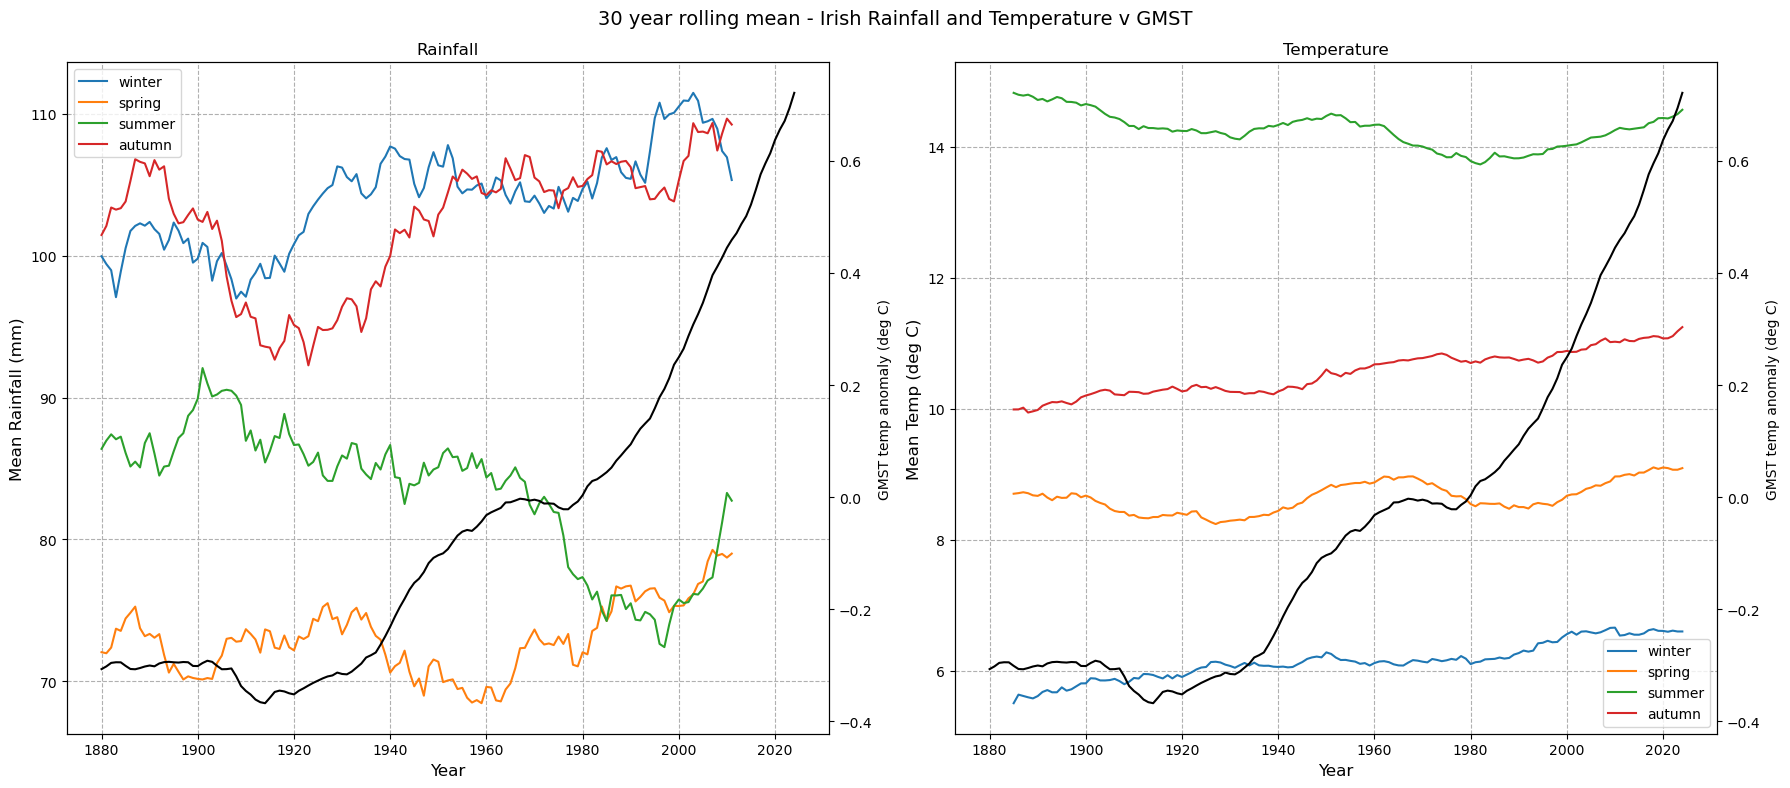

In [71]:
# Plot the rolling means for the irish temperature and rainfall data along with the GMST
fig, axs = plt.subplots(1,2, figsize=(18, 8))
fig.suptitle("30 year rolling mean - Irish Rainfall and Temperature v GMST", fontsize=14)
for i, season in enumerate(seasons_dict.keys()):
    axs[0].plot(rolling_means[f'{season} rainfall (mm)'], label=season)
    axs[1].plot(rolling_means[f'{season} temp (deg C)'], label=season)

axs[0].legend()
axs[0].grid(linestyle='--')
axs[0].set_ylabel('Mean Rainfall (mm)', fontsize=12)
axs[0].set_xlabel('Year', fontsize=12)
axs[0].set_title("Rainfall")
ax3 = axs[0].twinx()
ax3.plot(HadCRUT_Berkeley_mean['GMST Anomaly Yearly'].rolling(30).mean(), color='black', label = "GMST Temp Anomaly-30 yr rolling mean")
ax3.set_ylabel('GMST temp anomaly (deg C)')

axs[1].legend()
axs[1].grid(linestyle='--')
axs[1].set_ylabel('Mean Temp (deg C)', fontsize=12)
axs[1].set_xlabel('Year', fontsize=12)
axs[1].set_title("Temperature")
ax4 = axs[1].twinx()
ax4.plot(HadCRUT_Berkeley_mean['GMST Anomaly Yearly'].rolling(30).mean(), color='black', label = "GMST Temp Anomaly-30 yr rolling mean")
ax4.set_ylabel('GMST temp anomaly (deg C)')
fig.tight_layout()


In [163]:
rolling_means

,winter rainfall (mm),spring rainfall (mm),summer rainfall (mm),autumn rainfall (mm),winter temp (deg C),spring temp (deg C),summer temp (deg C),autumn temp (deg C)
datetime,,,,,,,,
1831-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1832-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1833-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1834-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1835-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-12-31,NaN,NaN,NaN,NaN,6.605833,9.101852,14.438907,11.072722
2020-12-31,NaN,NaN,NaN,NaN,6.593278,9.092185,14.432019,11.074722
2021-12-31,NaN,NaN,NaN,NaN,6.610056,9.067630,14.460241,11.107944


In [164]:
irish_met_analysis = pd.merge(rolling_means, HadCRUT_Berkeley_mean.rolling(30).mean(), how='inner', on=['datetime'])
# truncate to get rid of the nans
irish_met_analysis = irish_met_analysis.loc['1890-01-01':'2010-01-01'].copy()

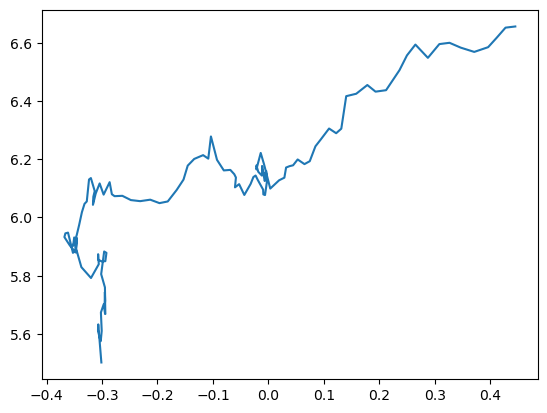

In [158]:
plt.plot(irish_met_analysis['GMST Anomaly Yearly'], irish_met_analysis['winter temp (deg C)'])

In [171]:

r = np.corrcoef(irish_met_analysis['GMST Anomaly Yearly'], irish_met_analysis['autumn temp (deg C)'])
lag = signal_lag(irish_met_analysis['GMST Anomaly Yearly'], irish_met_analysis['autumn temp (deg C)'])
# sklearn linear regression
regres = lin_reg(irish_met_analysis['GMST Anomaly Yearly'], irish_met_analysis['autumn temp (deg C)'])


pred = regres[3].predict([[0.5]])

#gmst = np.arange(0.6, 1.1, 0.1)
gmst = np.linspace(0.6, 1.1)
gmst = gmst.reshape(-1,1)
pred_autumn_temp = regres[3].predict(gmst)
#winter_temp_predict = np.linspace()
#regres[3]
#r
pred_autumn_temp


array([11.3435785 , 11.35564098, 11.36770346, 11.37976594, 11.39182842,
       11.4038909 , 11.41595338, 11.42801586, 11.44007834, 11.45214082,
       11.4642033 , 11.47626577, 11.48832825, 11.50039073, 11.51245321,
       11.52451569, 11.53657817, 11.54864065, 11.56070313, 11.57276561,
       11.58482809, 11.59689057, 11.60895305, 11.62101553, 11.63307801,
       11.64514049, 11.65720296, 11.66926544, 11.68132792, 11.6933904 ,
       11.70545288, 11.71751536, 11.72957784, 11.74164032, 11.7537028 ,
       11.76576528, 11.77782776, 11.78989024, 11.80195272, 11.8140152 ,
       11.82607767, 11.83814015, 11.85020263, 11.86226511, 11.87432759,
       11.88639007, 11.89845255, 11.91051503, 11.92257751, 11.93463999])

In [160]:
irish_met_analysis

,winter rainfall (mm),spring rainfall (mm),summer rainfall (mm),autumn rainfall (mm),winter temp (deg C),spring temp (deg C),summer temp (deg C),autumn temp (deg C),Year,Month,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%),Day,GMST Anomaly Yearly,GMST Anomaly Uncertainty,GMST 20yr anomaly,GMST 20yr Uncertainty,decimal date,Age_EDC3 (yrs BP)
datetime,,,,,,,,,,,,,,,,,,,,
1850-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1851-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-31,109.486667,78.453333,77.102222,108.638889,6.568722,8.829074,14.147796,10.984722,1990.5,6.5,0.307797,0.267816,0.347779,1.0,0.370903,0.030364,0.019236,NaN,1991.0,-41.0
2006-12-31,109.655556,79.261111,77.320000,109.364444,6.584944,8.822963,14.153685,11.036278,1991.5,6.5,0.342685,0.302469,0.382901,1.0,0.395936,0.030006,0.019361,NaN,1992.0,-42.0
2007-12-31,108.957778,78.856667,79.282222,107.423333,6.617056,8.862074,14.173907,11.072611,1992.5,6.5,0.367789,0.327477,0.408102,1.0,0.411219,0.029842,0.019494,NaN,1993.0,-43.0


## Analysis of CO2 and temperature data (800kyr BP to 1950)

Firstly, a common EDC3_date must be established for the ice core CO2 and temperature anomaly data. The temperature data was interpolated onto the EDC3 date data for the CO2.

The scatter plot of CO2 and temperature anomaly is plotted below. 

In [27]:
CH4_comp

,Age_EDC3 (yrs BP),CH4 [ppbv],CO2 [ppmv]
0,2342.0,NaN,284.7
1,2347.0,668.0,NaN
2,3634.0,636.0,272.8
3,3833.0,595.0,268.1
4,6220.0,NaN,262.2
...,...,...,...
663,412182.0,626.0,NaN
664,414080.0,653.0,NaN
665,414085.0,NaN,285.5
666,415452.0,678.0,NaN


In [28]:
# Analysis of CO2 and temperature (ice-core data)
temp_anom['Temperature']
temp_anom['Age_EDC3 (yrs BP)']

CO2_luthi_comp_plus['Age_EDC3 (yrs BP)']
CO2_luthi_comp_plus['CO2 (ppmv)']
# interpolate the temperature data onto the CO2 data to get a common time index for correlation etc
# https://stackoverflow.com/questions/46327022/calculating-correlation-of-different-time-series
new_temp = np.interp(CO2_luthi_comp_plus['Age_EDC3 (yrs BP)'], temp_anom['Age_EDC3 (yrs BP)'], temp_anom['Temperature'])
temp_co2_ch4_analysis_df = pd.concat([CO2_luthi_comp_plus[['Age_EDC3 (yrs BP)', 'CO2 (ppmv)']], pd.DataFrame(new_temp, columns=['Temp Anom Interp'])], axis=1)

# Interpolate the CH4 data onto the CO2 data to get a common time index for correlation etc
new_CH4 = np.interp(CO2_luthi_comp_plus['Age_EDC3 (yrs BP)'], CH4_comp['Age_EDC3 (yrs BP)'], CH4_comp['CH4 [ppbv]'])

# Concatenation of the CO2, temperature and CH4 data with common age/x-axis data
temp_co2_ch4_analysis_df = pd.concat([CO2_luthi_comp_plus[['Age_EDC3 (yrs BP)', 'CO2 (ppmv)']], pd.DataFrame(new_temp, columns=['Temp Anom Interp']), pd.DataFrame(new_CH4, columns=['CH4 Interp'])], axis=1)



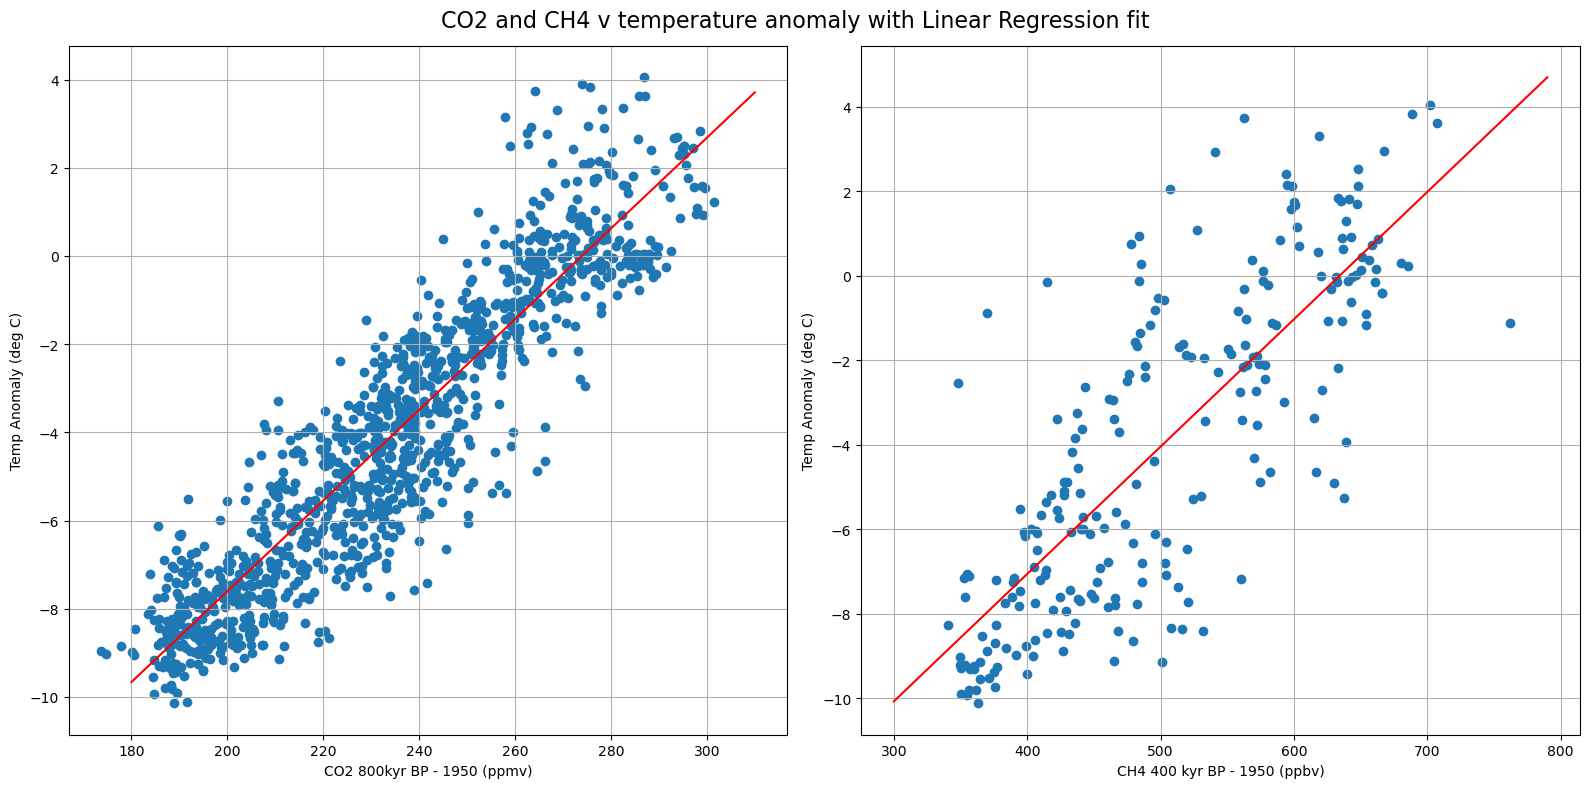

In [29]:
# Do the regression https://realpython.com/linear-regression-in-python/
# remove nans before attempting regression

temp_co2_df = temp_co2_ch4_analysis_df[['Age_EDC3 (yrs BP)', 'CO2 (ppmv)',	'Temp Anom Interp']].dropna().copy()
temp_ch4_df = temp_co2_ch4_analysis_df[['Age_EDC3 (yrs BP)', 'CH4 Interp',	'Temp Anom Interp']].dropna().copy()
# cut off where ch4 data stops (~417000 years)
temp_ch4_df = temp_ch4_df[temp_ch4_df['Age_EDC3 (yrs BP)']<417000]

r_sq_co2, m_temp_co2 , c_temp_co2 = lin_reg(temp_co2_df['CO2 (ppmv)'], temp_co2_df['Temp Anom Interp'])
linear_fit_x_co2 = np.arange(180, 320, 10)
linear_fit_y_co2 = linear_fit_x_co2 * m_temp_co2  + c_temp_co2


r_sq_ch4, m_temp_ch4 , c_temp_ch4 = lin_reg(temp_ch4_df['CH4 Interp'], temp_ch4_df['Temp Anom Interp'])
linear_fit_x_ch4 = np.arange(300, 800, 10)
linear_fit_y_ch4 = linear_fit_x_ch4 * m_temp_ch4  + c_temp_ch4

fig, axs = plt.subplots(1,2, figsize=(16, 8))
fig.suptitle('CO2 and CH4 v temperature anomaly with Linear Regression fit', fontsize=16)
axs[0].scatter(temp_co2_df['CO2 (ppmv)'], temp_co2_df['Temp Anom Interp'])
axs[0].plot(linear_fit_x_co2, linear_fit_y_co2, 'r', label='linear fit')
axs[0].set_xlabel("CO2 800kyr BP - 1950 (ppmv)")
axs[0].set_ylabel("Temp Anomaly (deg C)")
axs[0].grid()
axs[1].scatter(temp_ch4_df['CH4 Interp'], temp_ch4_df['Temp Anom Interp'])
axs[1].plot(linear_fit_x_ch4, linear_fit_y_ch4, 'r', label='linear fit')
axs[1].set_xlabel("CH4 400 kyr BP - 1950 (ppbv)")
axs[1].set_ylabel("Temp Anomaly (deg C)")
axs[1].grid()
fig.tight_layout()
plt.show()

In [30]:
temp_ch4_df

,Age_EDC3 (yrs BP),CH4 Interp,Temp Anom Interp
192,2433,665.861694,-0.407803
193,2536,663.300699,0.868967
194,2604,661.609946,0.169220
195,2728,658.526807,0.716765
196,2806,656.587413,0.362086
...,...,...,...
696,408600,641.456536,1.807742
701,412962,637.095890,0.623445
702,413948,651.122234,0.443840
704,415717,680.617664,0.310000


In [31]:
# calculate the signal lag 
lag_temp_co2 = signal_lag(temp_co2_df[['CO2 (ppmv)']].to_numpy(), temp_co2_df[['Temp Anom Interp']].to_numpy())
lag_temp_co2
lag_temp_ch4 = signal_lag(temp_ch4_df[['CH4 Interp']].to_numpy(), temp_ch4_df[['Temp Anom Interp']].to_numpy())
lag_temp_ch4
print(lag_temp_co2)
print(lag_temp_ch4)

-1
-1


## Climate Prediction
The prediction of climate in the future may be conducted based on continuing trends in global rising CO2 emissions, which in turn lead to higher Earth surface temperatures. Plotting the Mauna Loa CO2 Data against the GMST temperature anomaly data, it may be possible to infer future Earth surface temperature.

The acceleration in CO2 emissions is visible in the plot below. CO2 emissions are now at unprecedented levels and rising more sharply than at any time since the start of the modern industrial age.

### Methodology
- Here the Mauna Loa atmostpheric CO2 data from around the 1950s onwards has been joined to the latter part of the Bereiter ice-core CO2 data to create a composite CO2 trend from around 1850 onwards.
- The Berkelely GMST temperature anomaly data from around the 1850 onwards has been plotted along with the CO2 data.


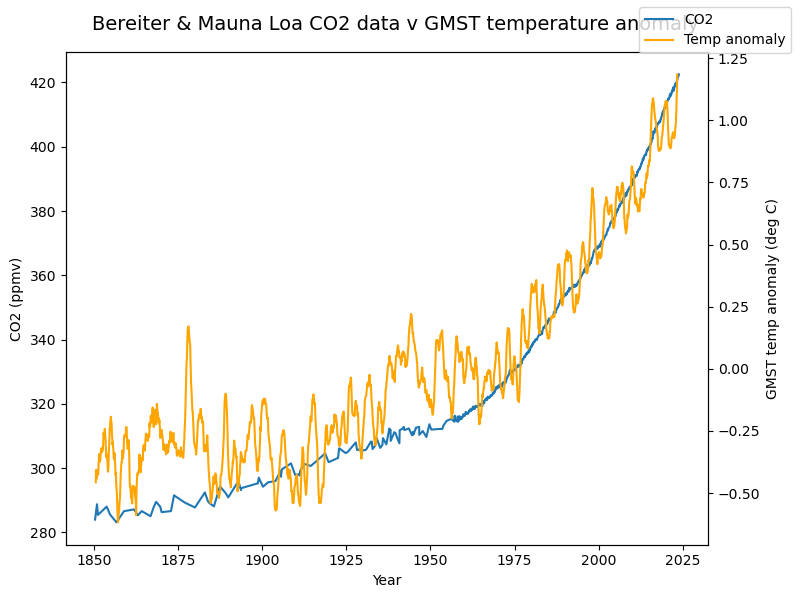

In [32]:
# plotting the CO2 and temp anomaly data
CO2_luthi_comp_plus['Age_EDC3 (yrs BP)'] = pd.to_numeric(CO2_luthi_comp_plus['Age_EDC3 (yrs BP)'])
CO2_luthi_comp_plus['CO2 (ppmv)'] = pd.to_numeric(CO2_luthi_comp_plus['CO2 (ppmv)'])

Luthi_since_1850 = CO2_luthi_comp_plus[(CO2_luthi_comp_plus['Age_EDC3 (yrs BP)'] < 100) & (CO2_luthi_comp_plus['Age_EDC3 (yrs BP)']>-8.2)].copy()

modern_CO2_composite = Luthi_since_1850[['Age_EDC3 (yrs BP)', 'CO2 (ppmv)']]
modern_CO2_composite['decimal date'] = 1950 - modern_CO2_composite['Age_EDC3 (yrs BP)']
modern_CO2_composite.drop(columns=['Age_EDC3 (yrs BP)'], inplace=True)

CO2_ML_m1 = CO2_ML_m[['decimal date', 'de-seasonalized']]
CO2_ML_m1 = CO2_ML_m1.rename(columns={'de-seasonalized': 'CO2 (ppmv)'}).copy()

modern_CO2_composite = pd.merge_ordered(modern_CO2_composite, CO2_ML_m1, on=['decimal date', 'CO2 (ppmv)'], how='outer')

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Bereiter & Mauna Loa CO2 data v GMST temperature anomaly', fontsize=14)
ax.plot(modern_CO2_composite['decimal date'], modern_CO2_composite['CO2 (ppmv)'], label='CO2')
ax2 = ax.twinx()
ax2.plot(GMST_anom_1850['decimal date'], GMST_anom_1850['GMST Anomaly Yearly'], color='orange', label='Temp anomaly')
ax.set_ylabel('CO2 (ppmv)')
ax2.set_ylabel('GMST temp anomaly (deg C)')
ax.set_xlabel('Year')
fig.legend()
fig.tight_layout()


In [33]:
modern_CO2_composite
new_temp_anom = np.interp(modern_CO2_composite['decimal date'], GMST_anom_1850['decimal date'], GMST_anom_1850['GMST Anomaly Yearly'])
new_temp_anom
modern_CO2_composite['temp'] = new_temp_anom
modern_CO2_composite.dropna(inplace=True)
modern_CO2_composite


,CO2 (ppmv),decimal date,temp
1,288.790395,1850.827000,-0.431824
2,285.465831,1851.105647,-0.423213
3,288.054437,1853.708275,-0.346007
4,285.565577,1854.718381,-0.232744
5,283.162101,1856.620328,-0.476271
...,...,...,...
884,419.220000,2023.041700,1.016011
885,419.430000,2023.125000,1.044000
886,419.580000,2023.208300,1.096979
887,420.730000,2023.291700,1.126024


In [34]:

lag_CO2_gmst = signal_lag(modern_CO2_composite[['CO2 (ppmv)']].to_numpy(), modern_CO2_composite[['temp']].to_numpy())
lag_CO2_gmst

0

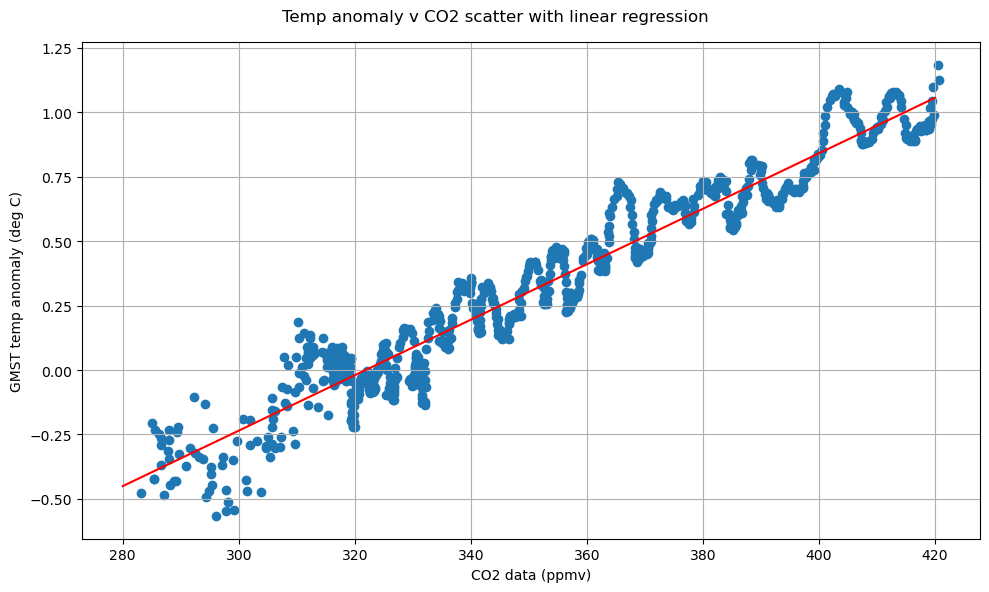

In [35]:
fig, ax = plt.subplots(1, figsize=(10, 6))
fig.suptitle('Temp anomaly v CO2 scatter with linear regression')
ax.scatter(modern_CO2_composite['CO2 (ppmv)'], modern_CO2_composite['temp'])
# do linear fit on CO2 and temp anomaly (1850 to present day)
r_sq_co2_temp, m_co2_temp, c_co2_temp = lin_reg(modern_CO2_composite['CO2 (ppmv)'], modern_CO2_composite['temp'])

linear_fit_x_temp = np.arange(280, 430, 10)
linear_fit_y_temp = linear_fit_x_temp * m_co2_temp  + c_co2_temp
ax.plot(linear_fit_x_temp, linear_fit_y_temp, color='r');
ax.set_ylabel('GMST temp anomaly (deg C)')
ax.set_xlabel('CO2 data (ppmv)')
ax.grid()
fig.tight_layout()


## Data Fusion

The aim is to fuse all the data used above into one dataframe for export to csv and json file.

Firstly, the 'modern' data (from circa 1850 to the present day) is joined together - this comprises:

 - The Irish temperature and rain data composites
 - The GMST anomaly data
 - The Mauna Loa data

All of the above data may be joined based on year and month.

Secondly, the ice core data has already been fused together and comprises:
 - The Luthi/Bereiter CO2 data 
 - The CH4 data 
 - The Jouvel temperature anomaly data 

This data has been combined based on EDC3 years. Because this data runs in reverse chronological order, it is flipped before joining to the modern data. Any overlap between the ancient and modern data is handled by the common EDC3 age data in both datasets.

Finally, the resulting dataframe is exported to fused_dataset/final_fused_dataset.csv and fused_dataset/final_fused_dataset.json

In [36]:
# Data fusion
# ireland_temp_rain_composite and GMST

modern_fused_dataset = pd.merge_ordered(ireland_temp_rain_composite.drop(columns=['decimal date']), GMST_anom_1850.drop(columns=['decimal date', 'Age_EDC3 (yrs BP)']), how='outer', on=['Year', 'Month'])
modern_fused_dataset

# Combine the Muana Loa CO2 dataframe
# rename some columns and drop others before fusing with the larger dataset
CO2_ML_m_renamed = CO2_ML_m.rename(columns={'monthly average': 'Muana Loa monthly avg CO2 (ppmv)', 'de-seasonalized': 'Muana Loa De-seasonalized CO2 (ppmv)',
                                             'unc of mean': 'Muana Loa Uncertainty of Mean CO2 (ppmv)', 'year':'Year', 'month':'Month'})
modern_fused_dataset = pd.merge_ordered(modern_fused_dataset, CO2_ML_m_renamed.drop(columns=['EDC3_gas_a (yr)', 'no_days', 'std', 'decimal date']), how='outer', on=['Year', 'Month'])
modern_fused_dataset


,Year,Month,Age_EDC3 (yrs BP),Mean Irish Air temp (deg C),Irish rainfall (mm),GMST Anomaly Yearly,GMST Anomaly Uncertainty,Muana Loa monthly avg CO2 (ppmv),Muana Loa De-seasonalized CO2 (ppmv),Muana Loa Uncertainty of Mean CO2 (ppmv)
0,1831,1,118.958333,3.550000,NaN,NaN,NaN,NaN,NaN,NaN
1,1831,2,118.875000,5.234211,NaN,NaN,NaN,NaN,NaN,NaN
2,1831,3,118.791667,8.176087,NaN,NaN,NaN,NaN,NaN,NaN
3,1831,4,118.708333,10.252273,NaN,NaN,NaN,NaN,NaN,NaN
4,1831,5,118.625000,12.627273,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2310,2023,7,-73.541667,15.080000,NaN,NaN,NaN,421.83,421.45,0.20
2311,2023,8,-73.625000,15.580000,NaN,NaN,NaN,419.68,421.57,0.19
2312,2023,9,-73.708333,14.880000,NaN,NaN,NaN,418.51,421.95,0.14
2313,2023,10,-73.791667,11.900000,NaN,NaN,NaN,418.82,422.10,0.17


In [37]:
# Flip the Paleo data before merging with the modern data, rename some columns, remove some etc.
# https://stackoverflow.com/questions/20444087/right-way-to-reverse-a-pandas-dataframe
climate_data_fusion_renamed = climate_data_fusion.rename(columns={'source': 'CO2 Ice-core data source', 'Temperature': 'Temperature Anomaly (Jouvel)'}).drop(columns=['CO2 [ppmv]'])

# Flip the dataframe and reset the index 
climate_data_fusion_renamed = climate_data_fusion_renamed.reindex(index=climate_data_fusion_renamed.index[::-1])
climate_data_fusion_renamed.reset_index(inplace=True, drop=True)

# Now merge with the modern dataset and export (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_json.html)
final_fused_dataset = pd.merge_ordered(modern_fused_dataset, climate_data_fusion_renamed, how='outer', on='Age_EDC3 (yrs BP)')
final_fused_dataset.to_csv('fused_dataset/final_fused_dataset.csv')
final_fused_dataset.to_json('fused_dataset/final_fused_dataset.json')

C:\Users\eilis.donohue\AppData\Local\Temp\ipykernel_9832\4072318812.py:10: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  final_fused_dataset = pd.merge_ordered(modern_fused_dataset, climate_data_fusion_renamed, how='outer', on='Age_EDC3 (yrs BP)')


## References

1. D. Luthi et al, "High-resolution carbon dioxide concentration record 650,000–800,000 years before present", Nature, vol. 453, May 2008, doi:10.1038/nature06949379.
2. J. Jouzel et al, "Orbital and Millennial Antarctic Climate Variability over the Past 800,000 Years.", Science, vol 317, pp 793-797, Jan 2007, doi: 10.1126
3. NOAA. (2023). *Mauna Loa Monthly average CO2 measurements* [Online]. Available: https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt 
4. Climate.gov. (2023). *Understanding Climage Change - Global Temperature* [Online]. Available: https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature
5. ACS. (2023). *The Keeling Curve: Carbon Dioxide Measurements at Mauna Loa* [Online]. Available: https://www.acs.org/education/whatischemistry/landmarks/keeling-curve.html
6. NOAA. (2023). *Global temperature anomaly* [Online]. Available: https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/ytd/12/1850-2022
7. Euan Mearns. (2023). *Image of the drilling locations for ice-cores* [Online]. Available: https://www.euanmearns.com/wp-content/uploads/2014/11/antarctic_ice_core_stations.jpg 
8. J.R. Petit et al, "Climate and atmospheric history of the past 420,000 years from the Vostok ice core, Antarctica", Nature, vol. 399, June 1999, doi:10.1038/20859
9. S. Noone et al, "Homogenization and analysis of an expanded long-term monthly rainfall network for the Island of Ireland (1850–2010)", International Journal of Climatology, vol. 36, October 2015, doi:10.1002 
10. Met Eireann. (2023). *Irish rainfall and temperature data (1711-2016)* [Online]. Available: https://www.met.ie/climate/available-data/long-term-data-sets/
11. UK Met Office (2023). *Met Office Hadley Centre Observations Datasets* [Online]. Available: https://www.metoffice.gov.uk/hadobs/
12. Wikipedia.com (2023) *Ice coring in Antarctica* [Online]. Available: https://en.wikipedia.org/wiki/European_Project_for_Ice_Coring_in_Antarctica
13. C. Mateus et al, "Reconstruction of a long-term historical daily maximum and minimum air temperature network dataset for Ireland (1831-1968)", Geoscience Data Journal, vol. 7, April 2020, doi: 10.1002  
14. C. Murphy et al, "The emergence of a climate change signal in long-term Irish meteorological observations",  Weather and Climate Extremes, vol 42, February 2023, doi: 10.1016
15. Berkeley Earth. (2023). *Global temperature data 1850-Recent* [Online]. Available: https://berkeleyearth.org/data/
16. B. Bereiter et al, "Geophysical Research Letters (2014) Revision of the EPICA Dome C CO2 record from 800 to 600 kyr before present", Geophysical Research Letters, vol. 42, December 2014, doi: 10.1002/2014GL061957
17. Met Eireann (2023). *Modern day temperature readings at various Irish weather stations* [Online]. Available: https://www.met.ie/climate/available-data/historical-data
18. C.P Morice et al, "An updated assessment of near-surface temperature change from 1850: the HadCRUT5 dataset", Journal of Geophysical Research, vol. 126, December 2020, doi: 10.1029/2019JD032361
19. Medium.com, *Multiple Series? Forecast them together with an Sklearn Model*, [Online]. Available: https://towardsdatascience.com/multiple-series-forecast-them-together-with-any-sklearn-model-96319d46269